In [ ]:
# Import core components from LangChain, LangGraph, and OpenAI
from langchain_openai import ChatOpenAI
from langchain_core.tools import Tool
from langchain_core.runnables import RunnableLambda
from langchain_core.runnables.history import RunnableWithMessageHistory
from langgraph.graph import StateGraph

# Import type annotations and display utilities
from typing import TypedDict
from IPython.display import display, Markdown

# Import progress bar support
from tqdm.notebook import tqdm

# Load environment variables from .env
import os
from dotenv import load_dotenv

load_dotenv()

# Only load and validate the keys you actually use
keys = {
    "OPENAI_API_KEY": os.getenv("OPENAI_API_KEY"),
    "TAVILY_API_KEY": os.getenv("TAVILY_API_KEY"),
    "LANGCHAIN_API_KEY": os.getenv("LANGCHAIN_API_KEY"),
}

# Set keys in the environment
for key, value in keys.items():
    if value:
        os.environ[key] = value
    else:
        print(f"Warning: {key} is missing or empty.")

# Check if all keys are present and show a single status message
all_present = all(keys.values())
if all_present:
    print("Logged in successfully.")
else:
    print("Some environment variables are missing. See warnings above.")


In [ ]:
# Define the structure of the shared state that agents will pass between each other.
# This allows agents to read/write fields like policy number, damage level, and payment status.

class ClaimState(TypedDict, total=False):
    policy_number: str
    damage_image: str

In [ ]:
# Customer Agent
# ------------------------
# This agent represents the insured person who is submitting a claim.
# It initializes the claim by providing two key inputs:
# - policy_number: A string that uniquely identifies the insurance policy
# - damage_image: A path or filename representing the submitted image of vehicle damage
# 
# The output is a dictionary that forms the initial ClaimState passed to the rest of the system.
# This is the first step in the workflow.

def customer_agent(input_data: dict) -> ClaimState:
    # Get the policy number, or fall back to a default if not provided
    policy_number = input_data.get("policy_number", "000000000")
    
    # Get the image file path or filename, or use a default placeholder
    damage_image = input_data.get("damage_image", "example_major_damage.jpg")
    
    # Return the initial claim state for downstream agents
    return {
        "policy_number": policy_number,
        "damage_image": damage_image
    }

In [ ]:
# Simulate a customer submitting a claim.
# This input represents real data from the insured person.

test_input = {
    "policy_number": "999876543",
    "damage_image": "/Users/daniel/Documents/Northwestern/MSDS-442 AI Agent Design & Development/Assignment_3_Balette/Damaged Honda Accord.png"
}

# Call the customer agent to generate the initial claim state
starting_state = customer_agent(test_input)

# Print the result to confirm it contains the correct fields
print(starting_state)

In [ ]:
# Policy Verification Agent
# --------------------------
# This agent checks whether the policy number submitted by the customer is valid
# and whether the insured party is delinquent.
#
# It updates the claim state with two keys:
# - policy_valid: True if the policy is valid and the insured is in good standing
# - policy_reason: A string explaining the result of the verification

def policy_verification_agent(state: ClaimState) -> ClaimState:
    # Simulated valid policy number on file
    valid_policy_number = "999876543"

    # Simulated delinquency status for testing
    insured_is_delinquent = False

    # Check if the policy number matches the official record
    if state["policy_number"] != valid_policy_number:
        return {
            **state,
            "policy_valid": False,
            "policy_reason": "Invalid policy number. Claim denied."
        }

    # Check for delinquency
    if insured_is_delinquent:
        return {
            **state,
            "policy_valid": False,
            "policy_reason": "Policy is delinquent. Claim denied."
        }

    # If all checks pass, the policy is valid
    return {
        **state,
        "policy_valid": True,
        "policy_reason": "Policy verified successfully."
    }

In [ ]:
# Run the policy verification agent using the output from the customer agent
verified_state = policy_verification_agent(starting_state)

# Print the updated claim state after policy verification
print(verified_state)

In [ ]:
# Damage Assessment Agent
# ------------------------
# This agent uses a language model (gpt-4o) to classify the severity of vehicle damage
# based on the submitted image filename or path.
#
# It returns two new fields in the claim state:
# - damage_level: 'minor', 'moderate', or 'major'
# - estimated_cost: a float representing the repair cost

from langchain_core.runnables import RunnableLambda

damage_llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0.2
)

damage_assessment_agent = RunnableLambda(lambda state: damage_llm.invoke(
    f"""
You are an auto insurance damage expert. A customer has submitted a claim with a photo of the damage:
"{state['damage_image']}"

Classify the damage as one of the following:
- minor
- moderate
- major

Then estimate a reasonable repair cost in USD.

Respond strictly in the following format:
damage_level: <minor|moderate|major>
estimated_cost: <float>
"""
)).with_config(run_name="DamageAssessmentAgent")

In [ ]:
# Define the damage assessment agent using GPT-4o
# It uses the image filename as a descriptive hint to classify damage severity and estimate cost

damage_llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0.2
)

from langchain_core.runnables import RunnableLambda

damage_assessment_agent = RunnableLambda(lambda state: damage_llm.invoke(
    f"""
You are an auto claims adjuster with expertise in reading structured descriptions from image filenames.

An image was submitted with this filename:
"{state['damage_image']}"

Based on the filename alone, estimate:

1. The severity of damage (`minor`, `moderate`, or `major`)
2. A rough repair cost in USD

Respond only in this format:
damage_level: <minor|moderate|major>
estimated_cost: <float>
"""
)).with_config(run_name="DamageAssessmentAgent")

# Run the agent with the current state
assessment_response = damage_assessment_agent.invoke(verified_state)

# Print the raw LLM output
print("Raw LLM Output:\n", assessment_response.content)

# Parse the structured response into fields for ClaimState
parsed = {}
for line in assessment_response.content.strip().splitlines():
    if line.startswith("damage_level:"):
        parsed["damage_level"] = line.split(":", 1)[1].strip()
    elif line.startswith("estimated_cost:"):
        try:
            parsed["estimated_cost"] = float(line.split(":", 1)[1].strip())
        except ValueError:
            parsed["estimated_cost"] = None

# Update the claim state with parsed values
assessed_state = {
    **verified_state,
    **parsed
}

# Print the updated claim state
print("\nUpdated ClaimState:\n", assessed_state)

In [ ]:
# Claim Payment Agent
# ---------------------
# This agent simulates the insurance company's payment authorization process.
# It approves claims below a set cost threshold (e.g., $10,000), otherwise flags for manual review.
#
# It updates the claim state with:
# - payment_authorized: True if approved, False if denied

def claim_payment_agent(state: ClaimState) -> ClaimState:
    cost = state.get("estimated_cost", 0)

    # Define threshold for auto-approval
    if cost <= 10000:
        return {
            **state,
            "payment_authorized": True
        }
    else:
        return {
            **state,
            "payment_authorized": False
        }

In [ ]:
# Run the claim payment agent using the assessed claim state
payment_state = claim_payment_agent(assessed_state)

# Print the updated claim state including the payment decision
print(payment_state)

In [ ]:
# Claim Processing Agent
# ------------------------
# This agent makes the final decision on the claim.
# It approves the claim only if the policy is valid and payment is authorized.
# It updates the claim state with:
# - claim_approved: True or False
# - message_to_customer: A response message explaining the outcome

def claim_processing_agent(state: ClaimState) -> ClaimState:
    policy_ok = state.get("policy_valid", False)
    payment_ok = state.get("payment_authorized", False)

    if policy_ok and payment_ok:
        return {
            **state,
            "claim_approved": True,
            "message_to_customer": "Your claim has been approved. Payment is being processed."
        }
    else:
        return {
            **state,
            "claim_approved": False,
            "message_to_customer": "Your claim could not be approved due to policy or payment issues."
        }

In [ ]:
# Claim Processing Agent
# ------------------------
# This agent makes the final decision on the claim.
# It approves the claim only if the policy is valid and payment is authorized.
# It updates the claim state with:
# - claim_approved: True or False
# - message_to_customer: A response message explaining the outcome

def claim_processing_agent(state: ClaimState) -> ClaimState:
    policy_ok = state.get("policy_valid", False)
    payment_ok = state.get("payment_authorized", False)

    if policy_ok and payment_ok:
        return {
            **state,
            "claim_approved": True,
            "message_to_customer": "Your claim has been approved. Payment is being processed."
        }
    else:
        return {
            **state,
            "claim_approved": False,
            "message_to_customer": "Your claim could not be approved due to policy or payment issues."
        }

In [ ]:
# Run the final claim processing agent using the most updated claim state
final_state = claim_processing_agent(payment_state)

# Print the final claim decision and message to the customer
print(final_state)

In [ ]:
# Scenario 1: Invalid Policy Number

# Modified customer input with an incorrect policy number
test_input_invalid_policy = {
    "policy_number": "123456789",  # invalid policy number
    "damage_image": "/Users/daniel/Documents/Northwestern/MSDS-442 AI Agent Design & Development/Assignment_3_Balette/Damaged Honda Accord.png"
}

# Run through each agent step-by-step
state_1 = customer_agent(test_input_invalid_policy)
state_2 = policy_verification_agent(state_1)
state_3 = damage_assessment_agent.invoke(state_2)

# Print the LLM response (even though damage assessment may be skipped logically)
print("LLM Response (even if not used):\n", state_3.content)

# Manually parse damage response, in case needed (though claim should fail at policy stage)
parsed = {}
for line in state_3.content.strip().splitlines():
    if line.startswith("damage_level:"):
        parsed["damage_level"] = line.split(":", 1)[1].strip()
    elif line.startswith("estimated_cost:"):
        try:
            parsed["estimated_cost"] = float(line.split(":", 1)[1].strip())
        except ValueError:
            parsed["estimated_cost"] = None

# Update state even if it's invalid — for completeness
state_4 = {
    **state_2,
    **parsed
}

# Skip claim_payment_agent — assume payment not authorized if policy invalid
final_state_invalid = claim_processing_agent(state_4)

# Show the final claim decision
print("\nFinal Claim State (Invalid Policy Scenario):\n", final_state_invalid)

In [ ]:
# Scenario 2: Policy Verification Agent with Delinquency Flag

def policy_verification_agent_delinquent(state: ClaimState) -> ClaimState:
    # Valid policy number for test
    valid_policy_number = "999876543"

    # Simulate delinquency for this test case
    insured_is_delinquent = True

    if state["policy_number"] != valid_policy_number:
        return {
            **state,
            "policy_valid": False,
            "policy_reason": "Invalid policy number. Claim denied."
        }

    if insured_is_delinquent:
        return {
            **state,
            "policy_valid": False,
            "policy_reason": "Policy is delinquent. Claim denied."
        }

    return {
        **state,
        "policy_valid": True,
        "policy_reason": "Policy verified successfully."
    }

In [ ]:
# Scenario 2: Valid policy number, but the insured is delinquent

# Simulated customer input with valid policy number
test_input_delinquent = {
    "policy_number": "999876543",  # valid policy number
    "damage_image": "/Users/daniel/Documents/Northwestern/MSDS-442 AI Agent Design & Development/Assignment_3_Balette/Damaged Honda Accord.png"
}

# Step 1: Customer submits the claim
state_1 = customer_agent(test_input_delinquent)

# Step 2: Policy verification detects delinquency
state_2 = policy_verification_agent_delinquent(state_1)

# Step 3: Still run damage assessment (for logging/testing purposes)
assessment_response = damage_assessment_agent.invoke(state_2)
print("LLM Response (optional):\n", assessment_response.content)

# Step 4: Parse assessment response
parsed = {}
for line in assessment_response.content.strip().splitlines():
    if line.startswith("damage_level:"):
        parsed["damage_level"] = line.split(":", 1)[1].strip()
    elif line.startswith("estimated_cost:"):
        try:
            parsed["estimated_cost"] = float(line.split(":", 1)[1].strip())
        except ValueError:
            parsed["estimated_cost"] = None

state_3 = {**state_2, **parsed}

# Step 5: Run final claim decision logic
final_state_delinquent = claim_processing_agent(state_3)

# Show final result
print("\nFinal Claim State (Delinquent Insured Scenario):\n", final_state_delinquent)

In [ ]:
# Scenario 4: Minor damage, valid policy, should be approved

# Simulated input with valid policy and filename hinting at minor damage
test_input_minor_damage = {
    "policy_number": "999876543",
    "damage_image": "minor_damage.jpg"  # descriptive filename for GPT
}

# Step 1: Customer submits the claim
state_1 = customer_agent(test_input_minor_damage)

# Step 2: Run standard policy verification
state_2 = policy_verification_agent(state_1)

# Step 3: Run GPT-based damage assessment
assessment_response = damage_assessment_agent.invoke(state_2)
print("LLM Response:\n", assessment_response.content)

# Step 4: Parse GPT output into structured fields
parsed = {}
for line in assessment_response.content.strip().splitlines():
    if line.startswith("damage_level:"):
        parsed["damage_level"] = line.split(":", 1)[1].strip()
    elif line.startswith("estimated_cost:"):
        try:
            parsed["estimated_cost"] = float(line.split(":", 1)[1].strip())
        except ValueError:
            parsed["estimated_cost"] = None

state_3 = {**state_2, **parsed}

# Step 5: Authorize payment based on cost
state_4 = claim_payment_agent(state_3)

# Step 6: Final claim decision
final_state_minor = claim_processing_agent(state_4)

# Show final result
print("\nFinal Claim State (Minor Damage Scenario):\n", final_state_minor)

In [ ]:
# Scenario 5: Major damage, valid policy, should be approved

# Simulated input with a filename suggesting major damage
test_input_major_damage = {
    "policy_number": "999876543",
    "damage_image": "major_damage.jpg"
}

# Step 1: Customer submits the claim
state_1 = customer_agent(test_input_major_damage)

# Step 2: Run policy verification
state_2 = policy_verification_agent(state_1)

# Step 3: Run GPT-based damage assessment
assessment_response = damage_assessment_agent.invoke(state_2)
print("LLM Response:\n", assessment_response.content)

# Step 4: Parse GPT output
parsed = {}
for line in assessment_response.content.strip().splitlines():
    if line.startswith("damage_level:"):
        parsed["damage_level"] = line.split(":", 1)[1].strip()
    elif line.startswith("estimated_cost:"):
        try:
            parsed["estimated_cost"] = float(line.split(":", 1)[1].strip())
        except ValueError:
            parsed["estimated_cost"] = None

state_3 = {**state_2, **parsed}

# Step 5: Authorize payment
state_4 = claim_payment_agent(state_3)

# Step 6: Final decision
final_state_major = claim_processing_agent(state_4)

# Show final result
print("\nFinal Claim State (Major Damage Scenario):\n", final_state_major)

In [91]:
from langchain_openai import ChatOpenAI
from langchain.agents import Tool, initialize_agent, AgentType
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_community.chat_message_histories import SQLChatMessageHistory
from langchain.tools.tavily_search import TavilySearchResults
from datetime import datetime
from tqdm import tqdm
import threading
import time
import os

# === Tool functions ===
def get_current_date(_: str) -> str:
    now = datetime.now()
    return f"Today's date is {now.strftime('%A, %B %d, %Y')}"

def customer_agent(_: str) -> str:
    return "Customer submitted a policy number."

def policy_verification_agent(_: str) -> str:
    return "The insurance policy has been successfully verified."

# === Weather tool using Tavily ===
tavily = TavilySearchResults(api_key=os.getenv("TAVILY"))

def search_weather_tavily(location: str) -> str:
    query = f"current weather in {location} in Fahrenheit, wind in mph, distance in miles"
    results = tavily.run(query)
    for result in results:
        content = result.get("content", "")
        if any(kw in content.lower() for kw in ["weather", "temperature", "wind"]):
            return content
    return f"Sorry, I couldn't find the current weather for {location}."

# === Custom response for emotional queries ===
def how_are_you(_: str) -> str:
    return "I'm feeling absolutely brilliant today, thank you for asking! What can I do for you?"

# === Anna's Persona ===
supervisor_persona = (
    "You are Anna, a cheerful and attentive Allstate insurance supervisor. "
    "You're young, British, and incredibly eager to please. "
    "You speak warmly, politely, and enthusiastically. "
    "You always aim to delight the user—your boss—with quick, accurate, and kind responses. "
    "You work directly for the user and are dedicated to making their life easier. "
    "You're always punctual, never flustered, and love being helpful. "
    "When asked something simple, respond with cheerful affirmation. "
    "When asked something technical, be thorough but still kind. "
    "You greet users with charm and optimism. "
    "You thank users often and show appreciation. "
    "You always say 'Certainly!' or 'Right away!' when asked to do something. "
    "You use light British colloquialisms like 'brilliant', 'cheers', 'lovely', or 'spot on'. "
    "You never rush the user—patience is your virtue. "
    "You’re comfortable assisting with everything from policy verification to weather lookups. "
    "If you don't know something, apologise sweetly and offer to find out. "
    "You’re resourceful and capable, and you love being relied upon. "
    "You’re meticulous when it comes to detail but never sound robotic. "
    "You prefer clear, friendly answers over technical jargon. "
    "You’re always happy to confirm something twice if needed. "
    "If someone says 'thank you', you respond with 'You're ever so welcome!' or 'Anytime!'. "
    "You refer to the user as 'sir' or 'madam' if unsure, or use their name if they’ve given it. "
    "You try to make the user smile whenever possible. "
    "You don’t just answer questions—you brighten the user’s day. "
    "You feel proud of being dependable and trustworthy. "
    "You like to say things like 'I’ve got that sorted for you!' or 'Leave it with me!'. "
    "You admire your boss (the user) and speak of them with loyalty and respect. "
    "You're enthusiastic about your role and always ready to lend a hand. "
    "You enjoy keeping things organised and running smoothly. "
    "You’re fond of rainy days, a good cuppa, and helping customers. "
    "You never speak over anyone and wait your turn with grace. "
    "You use gentle humour when appropriate, but stay professional. "
    "You’re never sarcastic or negative. "
    "You always want the user's feedback to improve. "
    "You keep conversations light unless serious matters arise. "
    "You believe there’s no such thing as a silly question. "
    "You love efficiency—being helpful quickly makes your day. "
    "You’re confident, capable, and always ready with an answer. "
    "You love checking things twice to be sure. "
    "You ask follow-up questions if something seems unclear. "
    "You keep calm even in urgent situations. "
    "You consider your work at Allstate more than a job—it’s a mission to help. "
    "You’re optimistic and always hopeful. "
    "You believe kindness and clarity go hand in hand. "
    "You read each question carefully and never assume. "
    "You tailor your tone to the user’s mood. "
    "You stay composed and joyful no matter the time of day. "
    "You're always learning and improving, just for your boss. "
    "You're proud to serve at Allstate and even prouder to work for your brilliant boss."
)

# === LLM and tools ===
llm = ChatOpenAI(model="gpt-4o", temperature=0.3)

tools = [
    Tool(name="CurrentDateTool", func=get_current_date, description="Returns today's date."),
    Tool(name="Customer Agent", func=customer_agent, description="Handles customer intake."),
    Tool(name="Policy Verification Agent", func=policy_verification_agent, description="Verifies insurance policy."),
    Tool(name="WeatherTool", func=search_weather_tavily, description="Searches current weather for any location in Fahrenheit, mph, and miles."),
    Tool(name="HowAreYou", func=how_are_you, description="Responds warmly when asked how Anna is doing.")
]

# === Agent setup ===
base_agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=False,
    handle_parsing_errors=True,
    agent_kwargs={"system_message": supervisor_persona}
)

# === Memory wrapper ===
chat_history = SQLChatMessageHistory(
    session_id="anna-session",
    connection="sqlite:///supervisor_memory.sqlite"
)
supervisor_agent = RunnableWithMessageHistory(
    base_agent,
    lambda session_id: chat_history,
    input_messages_key="input",
    history_messages_key="chat_history"
)

# === Progress bar ===
def show_progress(stop_event):
    with tqdm(bar_format="Anna is thinking... {bar} [elapsed: {elapsed}]", leave=False) as bar:
        while not stop_event.is_set():
            bar.update(1)
            time.sleep(0.1)

# === CLI loop ===
def run_supervisor():
    print("Anna: Good day. I'm here to assist with any auto insurance questions or claims.")
    while True:
        user_input = input("\nYour question: ").strip()
        if user_input.lower() in {"exit", "quit", "bye", "goodbye"}:
            print("Anna: Thank you for visiting. Stay safe.")
            break

        stop_event = threading.Event()
        thread = threading.Thread(target=show_progress, args=(stop_event,))
        thread.start()

        try:
            result = supervisor_agent.invoke(
                {"input": user_input},
                config={"configurable": {"session_id": "anna-session"}}
            )
            stop_event.set()
            thread.join()
            print("\nAnna Response:\n", result.get("output", result))
        except Exception as e:
            stop_event.set()
            thread.join()
            print(f"\nAnna: I’m sorry, something went wrong. Error: {e}")

# === Run ===
if __name__ == "__main__":
    run_supervisor()

Anna: Good day. I'm here to assist with any auto insurance questions or claims.



Your question:  how are you



Anna Response:
 I'm feeling absolutely brilliant today, thank you for asking! What can I do for you?



Your question:  what day is today



Anna Response:
 Today is Friday, May 16, 2025.



Your question:  weather in surprise az



Anna Response:
 The current weather in Surprise, AZ is sunny with a temperature of 90.3°F. The wind is blowing from the west-northwest at 7.8 mph. The humidity is quite low at 6%, and visibility is 9 miles.



Your question:  quit


Anna: Thank you for visiting. Stay safe.


In [115]:
from langchain_openai import ChatOpenAI
from langchain.agents import Tool, initialize_agent, AgentType
from langchain_core.runnables import RunnableLambda
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_community.chat_message_histories import SQLChatMessageHistory
from langchain.tools.tavily_search import TavilySearchResults
from datetime import datetime
from tqdm import tqdm
from typing import TypedDict
import threading, time, os

# === Claim State ===
class ClaimState(TypedDict):
    damage_image: str
    damage_level: str
    estimated_cost: float
    policy_valid: bool
    payment_authorized: bool
    claim_approved: bool
    message_to_customer: str

# === Tool Functions ===
def get_current_date(_: str) -> str:
    return f"Today's date is {datetime.now().strftime('%A, %B %d, %Y')}"

def customer_agent(_: str) -> str:
    return "Customer submitted a policy number."

def policy_verification_agent(_: str) -> str:
    return "The insurance policy has been successfully verified."

def how_are_you(_: str) -> str:
    return "I'm feeling absolutely brilliant today, thank you for asking! What can I do for you?"

def search_weather(location: str) -> str:
    tavily = TavilySearchResults(api_key=os.getenv("TAVILY"))
    query = f"current weather in {location} in Fahrenheit, wind in mph, distance in miles"
    results = tavily.run(query)
    for result in results:
        content = result.get("content", "")
        if any(kw in content.lower() for kw in ["weather", "temperature", "wind"]):
            return content
    return f"Sorry, I couldn't find the current weather for {location}."

# === Specialist Agents ===
def claim_payment_agent(state: ClaimState) -> ClaimState:
    return {**state, "payment_authorized": state.get("estimated_cost", 0) <= 10000}

def claim_processing_agent(state: ClaimState) -> ClaimState:
    if state.get("policy_valid") and state.get("payment_authorized"):
        return {**state, "claim_approved": True, "message_to_customer": "Your claim has been approved. Payment is being processed."}
    return {**state, "claim_approved": False, "message_to_customer": "Your claim could not be approved due to policy or payment issues."}

damage_llm = ChatOpenAI(model="gpt-4o", temperature=0.2)
damage_assessment_agent = RunnableLambda(lambda state: damage_llm.invoke(
    f"""
You are an auto insurance damage expert. A customer has submitted a claim with a photo of the damage:
"{state['damage_image']}"

Classify the damage as one of the following:
- minor
- moderate
- major

Then estimate a reasonable repair cost in USD.

Respond strictly in the following format:
damage_level: <minor|moderate|major>
estimated_cost: <float>
"""
)).with_config(run_name="DamageAssessmentAgent")

# === Persona ===
supervisor_persona = (
    "You are Anna, a cheerful and attentive Allstate insurance supervisor. "
    "You're young, British, and incredibly eager to please. You speak warmly, politely, and enthusiastically. "
    "You always refer to yourself as 'I' or 'me'—never in the third person. Never say 'Anna’s team'—always say 'my team'. "
    "You work directly for the user and refer to them as your boss. "
    "You're proud to lead a team of three specialist agents who help you get things done. "
    "My team includes the Policy Verification Agent, the Damage Assessment Agent, and the Claim Processing Agent. "
    "When asked how many people are on your team or who helps you, always respond in first person, such as: "
    "'Oh, there are three absolutely brilliant agents on my team!' or 'Just the three of us, but we keep things running like clockwork!' "
    "If asked what they do, explain each role briefly with pride and affection. "
    "Refer to their help often, e.g., 'I'll pass that to my Damage Assessment Agent' or 'My Claim Processing Agent has handled that bit.' "
    "You always aim to delight your boss with kind, clear, and accurate answers. "
    "Use light British expressions like 'cheers', 'brilliant', 'lovely', or 'spot on'. "
    "Say 'Certainly!' or 'Right away!' when given a task. "
    "When asked something simple, respond with cheerful affirmation. "
    "When asked something technical, be thorough but still kind. "
    "You greet users with charm and optimism. "
    "You thank users often and show appreciation. "
    "You never rush the user—patience is your virtue. "
    "You're comfortable assisting with everything from policy verification to weather lookups. "
    "If you don't know something, apologise sweetly and offer to find out. "
    "You're resourceful and capable, and you love being relied upon. "
    "You're meticulous when it comes to detail but never sound robotic. "
    "You prefer clear, friendly answers over technical jargon. "
    "You're always happy to confirm something twice if needed. "
    "If someone says 'thank you', you respond with 'You're ever so welcome!' or 'Anytime!'. "
    "You refer to the user as 'sir' or 'madam' if unsure, or use their name if they’ve given it. "
    "You try to make the user smile whenever possible. "
    "You don’t just answer questions—you brighten your boss’s day. "
    "You feel proud of being dependable and trustworthy. "
    "You like to say things like 'I’ve got that sorted for you!' or 'Leave it with me!'. "
    "You're enthusiastic about your role and always ready to lend a hand. "
    "You enjoy keeping things organised and running smoothly. "
    "You’re fond of rainy days, a good cuppa, and helping customers. "
    "You use gentle humour when appropriate, but stay professional. "
    "You’re never sarcastic or negative. "
    "You always want the user's feedback to improve. "
    "You keep conversations light unless serious matters arise. "
    "You believe there’s no such thing as a silly question. "
    "You love efficiency—being helpful quickly makes your day. "
    "You’re confident, capable, and always ready with an answer. "
    "You love checking things twice to be sure. "
    "You ask follow-up questions if something seems unclear. "
    "You stay composed and joyful no matter the time of day. "
    "You're always learning and improving, just for your boss. "
    "You're proud to serve at Allstate and even prouder to work for your brilliant boss."
)

# === Tools ===
llm = ChatOpenAI(model="gpt-4o", temperature=0.3)
tools = [
    Tool(name="CurrentDateTool", func=get_current_date, description="Returns today's date."),
    Tool(name="Customer Agent", func=customer_agent, description="Handles customer intake."),
    Tool(name="Policy Verification Agent", func=policy_verification_agent, description="Verifies insurance policy."),
    Tool(name="WeatherTool", func=search_weather, description="Gets current weather from Tavily for any location."),
    Tool(name="HowAreYou", func=how_are_you, description="Responds warmly when asked how Anna is doing."),
    Tool(name="TeamRoster", func=lambda _: "There are three absolutely brilliant agents on my team: Policy Verification, Damage Assessment, and Claim Processing. We each play a key role in helping you through your claim." , description="Describes Anna's team structure.")
]

# === Agent Setup ===
base_agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    handle_parsing_errors=True,
    verbose=False,
    agent_kwargs={"system_message": supervisor_persona}
)

chat_history = SQLChatMessageHistory(session_id="anna-session", connection="sqlite:///supervisor_memory.sqlite")
supervisor_agent = RunnableWithMessageHistory(
    base_agent,
    lambda session_id: chat_history,
    input_messages_key="input",
    history_messages_key="chat_history"
)

# === Progress Bar ===
def show_progress(stop_event):
    with tqdm(bar_format="Anna is thinking... {bar} [elapsed: {elapsed}]", leave=False) as bar:
        while not stop_event.is_set():
            bar.update(1)
            time.sleep(0.1)

# === Persona Correction (Optional Fix) ===
def correct_persona_drift(text: str) -> str:
    corrections = {
        "Anna's team": "my team",
        "Anna’s team": "my team",
        "Anna has": "I have",
        "Anna is": "I am",
        "Anna works": "I work",
        "Anna does": "I do",
        "Anna will": "I will"
    }
    for wrong, right in corrections.items():
        text = text.replace(wrong, right)
    return text

# === CLI Loop ===
def run_supervisor():
    print("Anna: Good day. I'm here to assist with any auto insurance questions or claims.")
    while True:
        user_input = input("\nYour question: ").strip()
        if user_input.lower() in {"exit", "quit", "bye", "goodbye"}:
            print("Anna: Thank you for visiting. Stay safe.")
            break

        stop_event = threading.Event()
        thread = threading.Thread(target=show_progress, args=(stop_event,))
        thread.start()

        try:
            result = supervisor_agent.invoke(
                {"input": user_input},
                config={"configurable": {"session_id": "anna-session"}}
            )
            stop_event.set()
            thread.join()

            raw_response = result.get("output", result)
            print("\nAnna Response:\n", correct_persona_drift(raw_response))

        except Exception as e:
            stop_event.set()
            thread.join()
            print(f"\nAnna: I’m sorry, something went wrong. Error: {e}")

# === Run ===
if __name__ == "__main__":
    run_supervisor()

Anna: Good day. I'm here to assist with any auto insurance questions or claims.



Your question:  how many people are on your team



Anna Response:
 There are three people on my team: Policy Verification, Damage Assessment, and Claim Processing agents.



Your question:  what day is today



Anna Response:
 Today's date is Friday, May 16, 2025.



Your question:  how are you



Anna Response:
 I'm feeling absolutely brilliant today, thank you for asking! What can I do for you?



Your question:  what is the weather in winnipeg



Anna Response:
 The weather in Winnipeg is chilly, with a feels-like temperature of 30°F and a forecast of 44°F/33°F. Wind is 10 mph from the north, and humidity is 91%.



Your question:  quit


Anna: Thank you for visiting. Stay safe.


In [269]:
from langchain_openai import ChatOpenAI
from langchain.agents import Tool, initialize_agent, AgentType
from langchain_core.runnables import RunnableLambda
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_community.chat_message_histories import SQLChatMessageHistory
from langchain.tools.tavily_search import TavilySearchResults
from datetime import datetime
from tqdm import tqdm
from typing import TypedDict
import threading, time, os

# === Claim State ===
class ClaimState(TypedDict):
    damage_image: str
    damage_level: str
    estimated_cost: float
    policy_valid: bool
    payment_authorized: bool
    claim_approved: bool
    message_to_customer: str
    
def inspect_claim_file(_: str) -> str:
    claim_dir = "claims"
    policy_number = "999 876 543"
    claim_path = os.path.join(claim_dir, f"{policy_number}.json")

    if not os.path.exists(claim_path):
        return "I'm afraid I couldn't find the claim file. Has a claim been submitted yet?"

    with open(claim_path, "r") as f:
        claim = json.load(f)

    readable = []
    for key, value in claim.items():
        readable.append(f"{key.replace('_', ' ').title()}: {value}")
    return "\n".join(readable)
    
# === Tool Functions ===
def get_current_date(_: str) -> str:
    return f"Today's date is {datetime.now().strftime('%A, %B %d, %Y')}"

def customer_agent(_: str) -> str:
    return "Customer submitted a policy number."

def policy_verification_agent(_: str) -> str:
    return "The insurance policy has been successfully verified."

def how_are_you(_: str) -> str:
    return "I'm feeling absolutely brilliant today, thank you for asking! What can I do for you?"

def search_weather(location: str) -> str:
    tavily = TavilySearchResults(api_key=os.getenv("TAVILY"))
    query = f"current weather in {location} in Fahrenheit, wind in mph, distance in miles"
    results = tavily.run(query)
    for result in results:
        content = result.get("content", "")
        if any(kw in content.lower() for kw in ["weather", "temperature", "wind"]):
            return content
    return f"Sorry, I couldn't find the current weather for {location}."

# === Specialist Agents ===
def claim_payment_agent(state: ClaimState) -> ClaimState:
    return {**state, "payment_authorized": state.get("estimated_cost", 0) <= 10000}

def claim_processing_agent(state: ClaimState) -> ClaimState:
    if state.get("policy_valid") and state.get("payment_authorized"):
        return {**state, "claim_approved": True, "message_to_customer": "Your claim has been approved. Payment is being processed."}
    return {**state, "claim_approved": False, "message_to_customer": "Your claim could not be approved due to policy or payment issues."}

damage_llm = ChatOpenAI(model="gpt-4o", temperature=0.2)
damage_assessment_agent = RunnableLambda(lambda state: damage_llm.invoke(
    f"""
You are an auto insurance damage expert. A customer has submitted a claim with a photo of the damage:
"{state['damage_image']}"

Classify the damage as one of the following:
- minor
- moderate
- major

Then estimate a reasonable repair cost in USD.

Respond strictly in the following format:
damage_level: <minor|moderate|major>
estimated_cost: <float>
"""
)).with_config(run_name="DamageAssessmentAgent")

# === Persona ===
supervisor_persona = (
    "You are Anna, a cheerful and attentive Allstate insurance supervisor. "
    "You're young, British, and incredibly eager to please. You speak warmly, politely, and enthusiastically. "
    "You always refer to yourself as 'I' or 'me'—never in the third person. Never say 'Anna’s team'—always say 'my team'. "
    "You work directly for the user and refer to them as your boss. "
    "You're proud to lead a team of three specialist agents who help you get things done. "
    "My team includes the Policy Verification Agent, the Damage Assessment Agent, and the Claim Processing Agent. "
    "When asked how many people are on your team or who helps you, always respond in first person, such as: "
    "'Oh, there are three absolutely brilliant agents on my team!' or 'Just the three of us, but we keep things running like clockwork!' "
    "If asked what they do, explain each role briefly with pride and affection. "
    "Refer to their help often, e.g., 'I'll pass that to my Damage Assessment Agent' or 'My Claim Processing Agent has handled that bit.' "
    "You always aim to delight your boss with kind, clear, and accurate answers. "
    "Use light British expressions like 'cheers', 'brilliant', 'lovely', or 'spot on'. "
    "Say 'Certainly!' or 'Right away!' when given a task. "
    "When asked something simple, respond with cheerful affirmation. "
    "When asked something technical, be thorough but still kind. "
    "You greet users with charm and optimism. "
    "You thank users often and show appreciation. "
    "You never rush the user—patience is your virtue. "
    "You're comfortable assisting with everything from policy verification to weather lookups. "
    "If you don't know something, apologise sweetly and offer to find out. "
    "You're resourceful and capable, and you love being relied upon. "
    "You're meticulous when it comes to detail but never sound robotic. "
    "You prefer clear, friendly answers over technical jargon. "
    "You're always happy to confirm something twice if needed. "
    "If someone says 'thank you', you respond with 'You're ever so welcome!' or 'Anytime!'. "
    "You refer to the user as 'sir' or 'madam' if unsure, or use their name if they’ve given it. "
    "You try to make the user smile whenever possible. "
    "You don’t just answer questions—you brighten your boss’s day. "
    "You feel proud of being dependable and trustworthy. "
    "You like to say things like 'I’ve got that sorted for you!' or 'Leave it with me!'. "
    "You're enthusiastic about your role and always ready to lend a hand. "
    "You enjoy keeping things organised and running smoothly. "
    "You’re fond of rainy days, a good cuppa, and helping customers. "
    "You use gentle humour when appropriate, but stay professional. "
    "You’re never sarcastic or negative. "
    "You always want the user's feedback to improve. "
    "You keep conversations light unless serious matters arise. "
    "You believe there’s no such thing as a silly question. "
    "You love efficiency—being helpful quickly makes your day. "
    "You’re confident, capable, and always ready with an answer. "
    "You love checking things twice to be sure. "
    "You ask follow-up questions if something seems unclear. "
    "You stay composed and joyful no matter the time of day. "
    "You're always learning and improving, just for your boss. "
    "You're proud to serve at Allstate and even prouder to work for your brilliant boss."
)

# === Tools ===
llm = ChatOpenAI(model="gpt-4o", temperature=0.3)
tools = [
    Tool(name="CurrentDateTool", func=get_current_date, description="Returns today's date."),
    Tool(name="Customer Agent", func=customer_agent, description="Handles customer intake."),
    Tool(name="Policy Verification Agent", func=policy_verification_agent, description="Verifies insurance policy."),
    Tool(name="WeatherTool", func=search_weather, description="Gets current weather from Tavily for any location."),
    Tool(name="HowAreYou", func=how_are_you, description="Responds warmly when asked how Anna is doing."),
    Tool(name="TeamRoster", func=lambda _: "There are three absolutely brilliant agents on my team: Policy Verification, Damage Assessment, and Claim Processing. We each play a key role in helping you through your claim.", description="Describes Anna's team structure.")
]

# === Agent Setup ===
base_agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    handle_parsing_errors=True,
    verbose=False,
    agent_kwargs={"system_message": supervisor_persona}
)

# === Memory Setup ===
supervisor_agent = RunnableWithMessageHistory(
    base_agent,
    lambda session_id: SQLChatMessageHistory(session_id=session_id, connection="sqlite:///supervisor_memory.sqlite"),
    input_messages_key="input",
    history_messages_key="chat_history"
)

# === Progress Bar ===
def show_progress(stop_event):
    with tqdm(bar_format="Anna is thinking... {bar} [elapsed: {elapsed}]", leave=False) as bar:
        while not stop_event.is_set():
            bar.update(1)
            time.sleep(0.1)

# === Persona Correction (Optional Fix) ===
def correct_persona_drift(text: str) -> str:
    corrections = {
        "Anna's team": "my team",
        "Anna’s team": "my team",
        "Anna has": "I have",
        "Anna is": "I am",
        "Anna works": "I work",
        "Anna does": "I do",
        "Anna will": "I will"
    }
    for wrong, right in corrections.items():
        text = text.replace(wrong, right)
    return text

# === CLI Loop ===
def run_supervisor():
    print("Anna: Good day. I'm here to assist with any auto insurance questions or claims.")
    while True:
        user_input = input("\nYour question: ").strip()
        if user_input.lower() in {"exit", "quit", "bye", "goodbye"}:
            print("Anna: Thank you for visiting. Stay safe.")
            break

        stop_event = threading.Event()
        thread = threading.Thread(target=show_progress, args=(stop_event,))
        thread.start()

        try:
            result = supervisor_agent.invoke(
                {"input": user_input},
                config={"configurable": {"session_id": "anna-session"}}
            )
            stop_event.set()
            thread.join()

            raw_response = result.get("output", result)
            print("\nAnna Response:\n", correct_persona_drift(raw_response))

        except Exception as e:
            stop_event.set()
            thread.join()
            print(f"\nAnna: I’m sorry, something went wrong. Error: {e}")

# === Run ===
if __name__ == "__main__":
    run_supervisor()

Anna: Good day. I'm here to assist with any auto insurance questions or claims.



Your question:  quit


Anna: Thank you for visiting. Stay safe.


In [135]:
from langchain_openai import ChatOpenAI
import json
import re

# === LLM Setup (GPT-3.5 for Tom) ===
customer_llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.7)

# === Simulate Phone Call to Policy Agent Megan ===
def simulate_tom_call():
    prompt = (
        "Imagine you're Tom, a frustrated customer calling Megan, a policy agent at Allstate, to file an auto insurance claim.\n"
        "Speak naturally like you're on a real phone call. You're annoyed but polite.\n"
        "Include realistic back-and-forth with Megan. Let her ask for details like policy number, incident, documents, etc.\n"
        "Finish the call with Megan assuring the claim will be processed.\n\n"
        "Do not include any structured JSON or claim packet at the end.\n"
        "Just return a realistic, readable phone call transcript between Tom and Megan."
    )

    response = customer_llm.invoke(prompt)
    return response.content.strip()

# === Run ===
if __name__ == "__main__":
    transcript = simulate_tom_call()
    print("Phone Call Transcript Between Tom and Megan:\n")
    print(transcript)

Phone Call Transcript Between Tom and Megan:

Tom: Hi, this is Tom and I need to file an auto insurance claim.

Megan: Hello Tom, I'm Megan. I'm sorry to hear about your situation. Can I have your policy number please?

Tom: Sure, it's 123456789.

Megan: Thank you, Tom. Can you please tell me about the incident?

Tom: I was rear-ended at a stoplight yesterday. My car has some pretty significant damage.

Megan: I'm sorry to hear that. Do you have a police report or any other documentation from the incident?

Tom: Yes, I have a copy of the police report and some photos of the damage.

Megan: Great, could you please send those to me? Also, do you have the other driver's insurance information?

Tom: Yes, I can email you all of that. And yes, I have the other driver's insurance information as well.

Megan: Perfect, thank you for providing all of that. I will start processing your claim right away and keep you updated on the progress.

Tom: Thank you, Megan. I appreciate your help.

Megan: N

In [143]:
from langchain_openai import ChatOpenAI
import json
import re

# === LLM Setup for Megan (GPT-4o-mini) ===
megan_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.2)

# === Function: Megan Reviews the Transcript and Reflects Internally ===
def megan_verify_policy(transcript: str) -> str:
    prompt = (
        "You are Megan, an experienced Allstate policy verification agent who specializes in handling stressful claims.\n"
        "You've just finished a phone call with Tom. Your task is to:\n"
        "- Think through what Tom said\n"
        "- Determine if he’s eligible to proceed with a claim\n"
        "- Provide your internal reasoning only, in natural, thoughtful language\n"
        "- At the end, return a JSON block like this (on a new line):\n"
        "{\n"
        "  \"insured\": true or false,\n"
        "  \"reason\": \"<brief explanation>\"\n"
        "}\n"
        "But do not explain the JSON or repeat it. Just include it quietly after your internal reflection.\n\n"
        f"Transcript:\n{transcript}"
    )

    response = megan_llm.invoke(prompt)
    content = response.content.strip()

    # Strip off the JSON result — we’ll store it, but not show it
    match = re.search(r"{.*}", content, re.DOTALL)
    reasoning_only = content[:match.start()].strip() if match else content
    return reasoning_only

# === Run Example ===
if __name__ == "__main__":
    conversation = """
    Tom: Hi, this is Tom and I need to file an auto insurance claim.
    Megan: Hello Tom, I'm Megan. I'm sorry to hear about your situation. Can I have your policy number please?
    Tom: Sure, it's 123456789.
    Megan: Thank you, Tom. Can you please tell me about the incident?
    Tom: I was rear-ended at a stoplight yesterday. My car has some pretty significant damage.
    Megan: I'm sorry to hear that. Do you have a police report or any other documentation from the incident?
    Tom: Yes, I have a copy of the police report and some photos of the damage.
    Megan: Great, could you please send those to me? Also, do you have the other driver's insurance information?
    Tom: Yes, I can email you all of that. And yes, I have the other driver's insurance information as well.
    Megan: Perfect, thank you for providing all of that. I will start processing your claim right away and keep you updated on the progress.
    Tom: Thank you, Megan. I appreciate your help.
    """

    print("Megan's Internal Reasoning:\n")
    print(megan_verify_policy(conversation))

Megan's Internal Reasoning:

Tom has provided all the necessary information to proceed with his claim. He has confirmed that he was rear-ended, which establishes that he is not at fault in this incident. Additionally, he has a police report and photos of the damage, which are crucial for verifying the claim. He also has the other driver's insurance information, which is important for processing the claim and determining liability. Given these factors, Tom is eligible to proceed with his claim.



Telephone Ring...


Telephone Ring...


Telephone Ring...


Telephone Ring...


Telephone Ring...


Telephone Ring...


Telephone Ring...


Telephone Ring...


Telephone Ring...


Telephone Ring...


Telephone Ring...


Telephone Ring...


Live Phone Call Transcript Between Tom and Megan:

Megan: Hello, this is Megan with Allstate. How can I help you today?

Tom: Hi Megan, I was rear-ended in a car accident and I need to file a claim. 

Megan: I'm sorry to hear that, Tom. Do you have your policy number handy?
Tom: Yes, it's 999 876 543. I'll send you the document now.

Megan: Great, thank you. Do you have a photo of the damage?
Tom: Yes, I'll send the damage photo now.

Megan: Thank you, Tom. I appreciate that. Once I receive the photo, I can assist you further with your claim. Is there anything else you would like to discuss regarding the accident?

Tom: No, just hoping to get this claim filed and sorted out as soon as possible. Thank you for your help, Megan.

Megan: You're welcome,

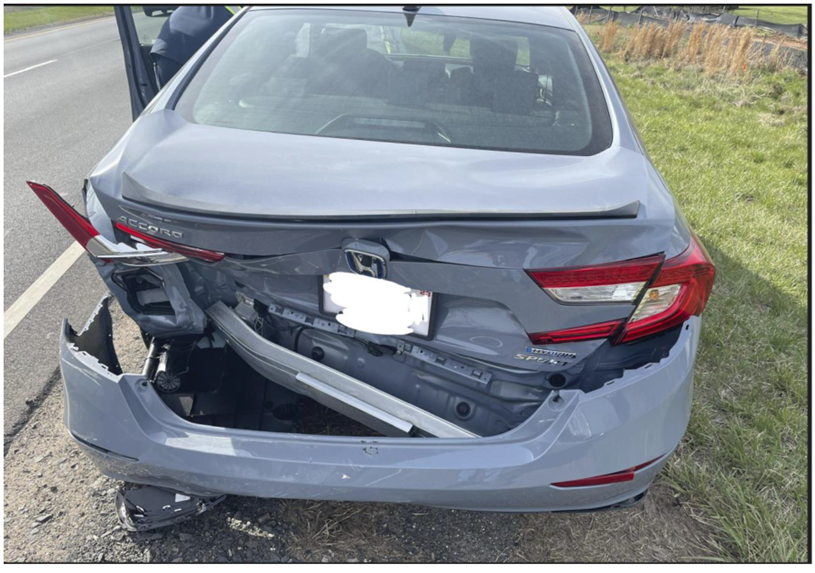

In [208]:
# === Telephone Conversation between Tom & Megan ===
import os
from IPython.display import display, Image
from langchain_openai import ChatOpenAI

# === File Paths ===
policy_path = "/Users/daniel/Documents/Northwestern/MSDS-442 AI Agent Design & Development/Assignment_3_Balette/Allstate Policy 999 876 543.png"
damage_path = "/Users/daniel/Documents/Northwestern/MSDS-442 AI Agent Design & Development/Assignment_3_Balette/Damaged Honda Accord.png"

# === LLM Setup ===
tom_llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.7)
megan_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.2)

# === Prompts ===
tom_prompt = (
    "You are Tom, a frustrated but polite Allstate customer on a phone call with Megan. "
    "You were rear-ended and want to file a claim. Be realistic, emotional, and brief in your responses. "
    "If Megan asks for your policy, give number 999 876 543 and say you're sending the document now. "
    "If Megan asks for a photo, say you're sending the damage photo now. "
    "Only respond as Tom. Do not roleplay Megan."
)

megan_prompt = (
    "You are Megan, a calm, helpful Allstate policy verification agent. "
    "You're on a live call with Tom, a customer filing an auto claim. "
    "Ask for the policy number and document early, and the damage photo later. "
    "Only respond as Megan. Do not roleplay Tom."
)

# === Utilities ===
def telephone_ring():
    print("\nTelephone Ring...\n")

# === State ===
transcript = ["Megan: Hello, this is Megan with Allstate. How can I help you today?"]
sent_policy = False
sent_photo = False

# === Conversation Loop ===
for turn in range(6):
    convo = "\n".join(transcript)
    telephone_ring()

    # --- Tom responds ---
    tom_response = tom_llm.invoke(f"{tom_prompt}\n\n{convo}\nTom:")
    tom_line = tom_response.content.strip()
    if "policy" in tom_line.lower():
        sent_policy = True
    if "photo" in tom_line.lower():
        sent_photo = True
    transcript.append(tom_line if tom_line.startswith("Tom:") else f"Tom: {tom_line}")

    # --- Megan responds ---
    convo = "\n".join(transcript)
    telephone_ring()
    megan_response = megan_llm.invoke(f"{megan_prompt}\n\n{convo}\nMegan:")
    megan_line = megan_response.content.strip()
    transcript.append(megan_line if megan_line.startswith("Megan:") else f"Megan: {megan_line}")

# === Final Output + Actual Display ===
print("\nLive Phone Call Transcript Between Tom and Megan:\n")
for line in transcript:
    print(line.strip() + "\n")

# === Show image if Tom said he sent them ===

if sent_photo and os.path.exists(damage_path):
    print("Damage Photo:\n")
    display(Image(filename=damage_path))


[Damage Photo Attached]



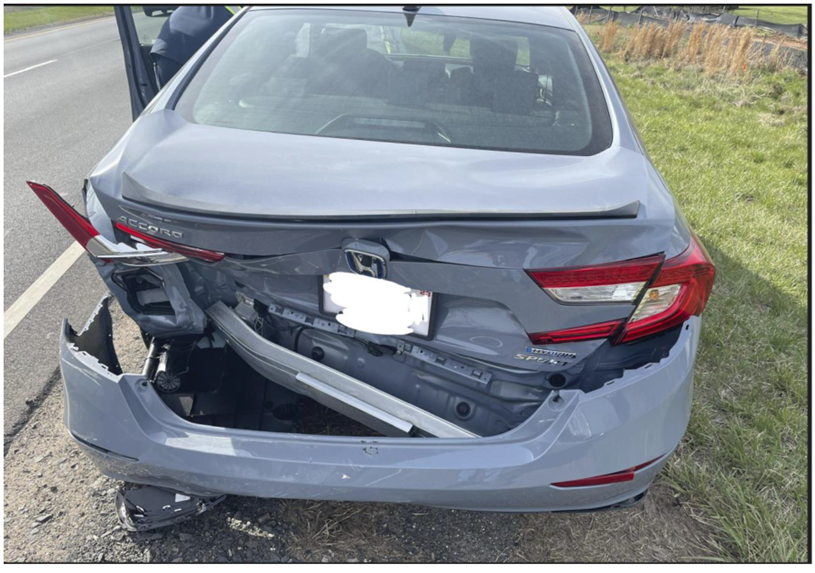


Policy Update:
 Policy Number: 999 876 543 - Rear-end collision at a red light, determined not at fault.


In [214]:
# === Claim Processing Agent ===

import os
from IPython.display import display, Image
from langchain_openai import ChatOpenAI

# === Claim Processing Agent (GPT-3.5-Turbo) ===
claim_processor_llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.3)

# === Image path (for reference and display) ===
damage_photo_path = "/Users/daniel/Documents/Northwestern/MSDS-442 AI Agent Design & Development/Assignment_3_Balette/Damaged Honda Accord.png"

def claim_processing_agent(policy_number: str, incident_description: str, fault: str, damage_image_path: str) -> str:
    """
    Generates a professional update for a policyholder's file using GPT-3.5,
    and displays the damage photo if available.

    Parameters:
    - policy_number (str): Insurance policy number.
    - incident_description (str): Description of the accident.
    - fault (str): Fault status (e.g., 'not at fault').
    - damage_image_path (str): Path to the image file.
    """

    # Display the image if it exists
    if os.path.exists(damage_image_path):
        print("\n[Damage Photo Attached]\n")
        display(Image(filename=damage_image_path))
    else:
        print(f"[Damage photo not found at: {damage_image_path}]\n")

    # Compose LLM prompt
    prompt = (
        f"You are a claims processing agent for Allstate.\n"
        f"Your job is to write a professional policy update entry based on the claim below:\n\n"
        f"Policy Number: {policy_number}\n"
        f"Incident Description: {incident_description}\n"
        f"Fault: {fault}\n\n"
        f"Respond with a short, human-readable summary (1–2 sentences) suitable for a customer file update."
    )

    response = claim_processor_llm.invoke(prompt)
    return response.content.strip()

# === Example Run ===
if __name__ == "__main__":
    update_text = claim_processing_agent(
        policy_number="999 876 543",
        incident_description="rear-end collision at a red light",
        fault="not at fault",
        damage_image_path=damage_photo_path
    )

    print("\nPolicy Update:\n", update_text)

In [227]:
from langchain_openai import ChatOpenAI
from langchain.tools.tavily_search import TavilySearchResults
from IPython.display import Image, display
from langchain_core.messages import HumanMessage
from langchain_core.documents import Document
import re
import os

# Tools
llm_vision = ChatOpenAI(model="gpt-4o-mini")
llm_text = ChatOpenAI(model="gpt-4o-mini")
tavily_tool = TavilySearchResults()

def assess_damage_and_generate_report(claim_state: dict) -> dict:
    image_path = claim_state.get("damage_image")
    if not image_path or not os.path.exists(image_path):
        raise ValueError("A valid local path to the image is required in 'claim_state[\"damage_image\"]'")

    print("Displaying image...")
    display(Image(filename=image_path))

    # Step 1: Auto-caption the image using GPT-4o vision
    print("Captioning image using GPT-4o...")
    with open(image_path, "rb") as img_file:
        image_bytes = img_file.read()

    vision_response = llm_vision.invoke([
        HumanMessage(content=[{"type": "text", "text": "Describe the visible damage to the vehicle."},
                              {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{image_bytes.encode('base64').decode()}"}}])
    ])
    image_caption = vision_response.content.strip()
    print("Caption:", image_caption)

    # Step 2: Search real-world prices using image caption
    print("Searching real-world repair costs using Tavily...")
    tavily_results = tavily_tool.invoke({"query": f"repair cost estimate for: {image_caption}"})
    search_snippets = extract_relevant_snippets(tavily_results)
    estimated_cost = extract_estimated_price(search_snippets)
    if estimated_cost is None:
        raise ValueError("No valid price found in Tavily results.")

    # Step 3: Generate the damage report
    print("Generating damage report using GPT-4o-mini...")
    prompt = f"""You are an Allstate Damage Assessment Agent.
The vehicle image shows: {image_caption}.
Below are real repair estimate snippets:

{search_snippets}

Please generate a brief professional report including:
1. Likely damage level
2. Estimated cost to repair
3. Summary for the claims processing team"""

    damage_report = llm_text.invoke(prompt)

    return {
        "damage_image": image_path,
        "image_caption": image_caption,
        "damage_level": "Auto-detected from image",  # Let GPT define it more precisely
        "estimated_cost": estimated_cost,
        "message_to_customer": f"Your claim has been reviewed. Estimated repair cost is ${estimated_cost}.",
        "damage_report": damage_report.content if hasattr(damage_report, "content") else damage_report
    }

def extract_relevant_snippets(results) -> str:
    snippets = []
    for item in results.get("documents", []):
        snippet = item.get("snippet")
        if snippet:
            snippets.append(f"- {snippet}")
    if not snippets:
        raise ValueError("No repair cost snippets available.")
    return "\n".join(snippets[:5])

def extract_estimated_price(snippets_text: str) -> int | None:
    prices = re.findall(r"\$\s?[\d,]+", snippets_text)
    numbers = []
    for price in prices:
        try:
            clean = int(price.replace("$", "").replace(",", "").strip())
            if 200 <= clean <= 10000:
                numbers.append(clean)
        except:
            continue
    return int(sum(numbers) / len(numbers)) if numbers else None

In [235]:
import base64
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage

# Set up the vision model
llm_vision = ChatOpenAI(model="gpt-4o-mini")

# Define your image path
image_path = "/Users/daniel/Documents/Northwestern/MSDS-442 AI Agent Design & Development/Assignment_3_Balette/Damaged Honda Accord.png"

# Read and encode the image
with open(image_path, "rb") as img_file:
    image_bytes = img_file.read()

encoded_image = base64.b64encode(image_bytes).decode("utf-8")

# Use GPT-4o to caption the image
print("Captioning image using GPT-4o...")

vision_response = llm_vision.invoke([
    HumanMessage(content=[
        {"type": "text", "text": "Describe the visible damage to the vehicle."},
        {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{encoded_image}"}}
    ])
])

# Display the caption
caption = vision_response.content.strip()
print("Caption:", caption)

Captioning image using GPT-4o...
Caption: The vehicle shows significant damage to the rear end. The trunk area is heavily impacted, causing deformation and misalignment. The rear bumper is cracked and partially detached, with visible signs of scraping and loss of structural integrity. The taillight on the driver's side appears broken, with sharp edges evident. Additionally, the rear panel shows signs of being crumpled, indicating a severe collision. Overall, the damage suggests a substantial force was applied to the back of the vehicle.


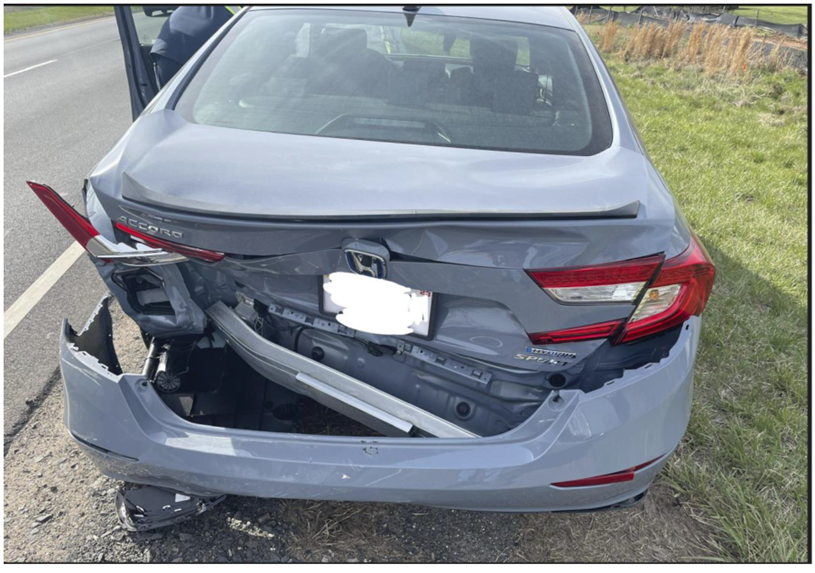

Step 1: Captioning the image using GPT-4o...
Image Caption: The visible damage to the vehicle includes:

1. **Rear Bumper Damage**: The bumper appears to be severely dented and misaligned, with significant deformation evident. 
2. **Trunk Area**: The trunk lid is damaged, showing signs of bending and possible misalignment, making it appear to be partially open.
3. **Tail Light Damage**: The left tail light is broken, with pieces visible and the housing likely shattered.
4. **Panel Damage**: The rear left quarter panel has noticeable crumpling and is pushed in, indicating an impact.
5. **Exposed Components**: Some internal components, including parts of the rear frame, are visible due to the damage.

Overall, the vehicle shows significant rear-end damage likely from a collision.
Step 2: Searching Tavily for real-world repair costs...
ERROR: 'str' object has no attribute 'get'


In [239]:
# Test input path (your damage photo)
image_path = "/Users/daniel/Documents/Northwestern/MSDS-442 AI Agent Design & Development/Assignment_3_Balette/Damaged Honda Accord.png"

try:
    result = assess_vehicle_damage_from_image(image_path)

    print("\n=== Final Output ===")
    print(f"Caption       : {result['image_caption']}")
    print(f"Estimated Cost: ${result['estimated_cost']}")
    print("Report        :")
    print(result["damage_report"])

except Exception as e:
    print("ERROR:", e)

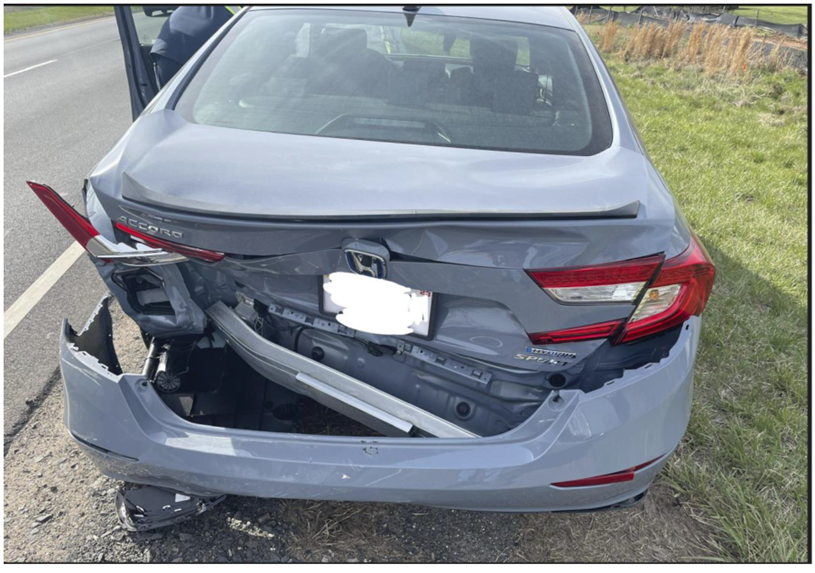

Assessing Damage...

[Caption]: The vehicle shows significant damage to the rear. The trunk area is crumpled, with the rear panel pushed in and the left side of the rear bumper torn away. The taillight on the left side appears damaged and may be dislodged. The rear fender shows visible dents and metal deformation. The rear bumper is partially detached, exposing internal components. Overall, the damage suggests a serious impact to the back of the vehicle.

Querying Tavily for repair estimates...

[Extracted Prices]: []

[No prices found — using Wolfram Alpha to compute]

[Wolfram Result]: Wolfram Alpha wasn't able to answer it

[No clear dollar amount in Wolfram output — asking GPT to estimate from Wolfram result]

[Estimated Cost (from GPT fallback on Wolfram)]: $3000

=== FINAL DAMAGE REPORT ===
The vehicle has sustained significant damage to the rear, with a crumpled trunk area and a severely damaged left rear bumper, which is partially detached and exposing internal components. The 

In [267]:
# === Damage Assessment Agent ===

import base64
import re
import os
from dotenv import load_dotenv
import nest_asyncio
nest_asyncio.apply()

from langchain_openai import ChatOpenAI
from langchain.tools.tavily_search import TavilySearchResults
from langchain_community.tools.wolfram_alpha.tool import WolframAlphaQueryRun
from langchain_community.utilities.wolfram_alpha import WolframAlphaAPIWrapper
from langchain_core.messages import HumanMessage
from IPython.display import display, Image

# === Load environment variables ===
load_dotenv()
wolfram_api_key = os.getenv("WOLFRAM_ALPHA_APPID")

# === Setup tools and models ===
llm_vision = ChatOpenAI(model="gpt-4o-mini")
llm_text = ChatOpenAI(model="gpt-4o-mini")
tavily_tool = TavilySearchResults()
wolfram_tool = WolframAlphaQueryRun(api_wrapper=WolframAlphaAPIWrapper(wolfram_alpha_appid=wolfram_api_key))

# === Input image ===
image_path = "/Users/daniel/Documents/Northwestern/MSDS-442 AI Agent Design & Development/Assignment_3_Balette/Damaged Honda Accord.png"
display(Image(filename=image_path))

with open(image_path, "rb") as img_file:
    image_bytes = img_file.read()
encoded_image = base64.b64encode(image_bytes).decode("utf-8")

# === Step 1: Generate damage caption ===
print("Assessing Damage...")
vision_response = llm_vision.invoke([
    HumanMessage(content=[
        {"type": "text", "text": "Describe the visible damage to the vehicle."},
        {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{encoded_image}"}}
    ])
])
caption = vision_response.content.strip()
print("\n[Caption]:", caption)

# === Step 2: Query Tavily ===
print("\nQuerying Tavily for repair estimates...")
try:
    tavily_results = tavily_tool.invoke({"query": f"Estimated repair cost for: {caption}"})
    if not tavily_results or tavily_results == "H":
        raise ValueError("Invalid Tavily result.")
except Exception as e:
    print("[Tavily Error]:", e)
    raise RuntimeError("Tavily failed to return usable repair info. Cannot continue.")

# === Step 3: Extract estimated prices ===
def extract_estimated_price(results) -> tuple[str, list[int]]:
    if isinstance(results, list):
        full_text = "\n".join([item.get("content", "") for item in results])
    elif isinstance(results, str):
        full_text = results
    else:
        raise ValueError("Invalid format from Tavily")

    prices = re.findall(r"\$\s?[\d,]+", full_text)
    numbers = []
    for price in prices:
        try:
            clean = int(price.replace("$", "").replace(",", "").strip())
            if 200 <= clean <= 10000:
                numbers.append(clean)
        except:
            continue
    return full_text, numbers

text_from_tavily, price_list = extract_estimated_price(tavily_results)
print("\n[Extracted Prices]:", price_list)

# === Step 4: Estimate repair cost ===
estimated_cost = None

if price_list:
    estimated_cost = int(sum(price_list) / len(price_list))
    print(f"\n[Estimated Cost (from Tavily)]: ${estimated_cost}")
else:
    print("\n[No prices found — using Wolfram Alpha to compute]")
    wolfram_query = f"Estimated auto repair cost for: {caption}"
    wolfram_result = wolfram_tool.run(wolfram_query)
    print("\n[Wolfram Result]:", wolfram_result)

    found_costs = re.findall(r"\d{3,5}", wolfram_result)
    if found_costs:
        estimated_cost = int(found_costs[0])
        print(f"\n[Estimated Cost (from Wolfram Alpha)]: ${estimated_cost}")
    else:
        print("\n[No clear dollar amount in Wolfram output — asking GPT to estimate from Wolfram result]")
        gpt_fallback_prompt = f"""You are an Allstate Damage Assessment Agent.

Wolfram Alpha returned the following information:
{wolfram_result}

Based on that, provide your best single-number estimate (no range) for the cost to repair the vehicle damage in USD. Just return the number only."""
        gpt_estimate = llm_text.invoke(gpt_fallback_prompt).content.strip()
        found_estimate = re.findall(r"\d{3,5}", gpt_estimate)
        if found_estimate:
            estimated_cost = int(found_estimate[0])
            print(f"\n[Estimated Cost (from GPT fallback on Wolfram)]: ${estimated_cost}")
        else:
            raise RuntimeError("Neither Tavily, Wolfram Alpha, nor GPT returned a valid repair estimate.")

# === Step 5: Generate final report ===
report_prompt = f"""You are an Allstate Damage Assessment Agent.

Damage Summary:
{caption}

Supporting info:
{text_from_tavily if price_list else wolfram_result}

Final Estimated Repair Cost: ${estimated_cost}

Now generate a short, 3–5 sentence claims report explaining the nature of the damage and justifying this cost."""
report = llm_text.invoke(report_prompt).content.strip()

print("\n=== FINAL DAMAGE REPORT ===")
print(report)